# matrix fold of gate X (adapted) with 00h input

In [1]:
# Checking the version of PYTHON; we only support > 3.5
import sys
sys.path.append('../../../Transferências/qiskit-sdk-py-master')

if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')

import qiskit
import numpy

# Import the QISKit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QuantumProgram, Result
from qiskit import available_backends, execute, register, get_backend
import getpass, time
import Qconfig
from qiskit import compile


# import basic plot tools
from qiskit.tools.visualization import plot_histogram, circuit_drawer, plot_state

#information of API
from IBMQuantumExperience import IBMQuantumExperience

# Import tomography tools
import qiskit.tools.qcvv.tomography as tomo

# Aditional packages
from qiskit.tools.qi.qi import *


In [2]:
api = IBMQuantumExperience(Qconfig.APItoken)
myCredits = api.get_my_credits()

print(myCredits)

# set the APIToken and API url
try:
    register(Qconfig.APItoken,Qconfig.config['url'])

    print('\nYou have access to great power!')
    print(available_backends({'local': False, 'simulator': False}))
    print('Available simulators:')
    print(available_backends({'simulator':True}))
except: 
    print('Something went wrong.\nDid you enter a correct token?')

{'promotional': 0, 'remaining': 15, 'maxUserType': 15}

You have access to great power!
['ibmq_16_rueschlikon', 'ibmq_5_tenerife', 'ibmq_5_yorktown']
Available simulators:
['ibmq_qasm_simulator', 'local_qasm_simulator', 'local_statevector_simulator', 'local_unitary_simulator']


In [3]:
# Creating Programs
# create QuantumProgram object instance.
qp = QuantumProgram()

# Creating Registers
# create Quantum Register called "qr" with 3 qubits 
qr = qp.create_quantum_register('qr', 3)
# create Classical Register  called "cr" with 3 bits
cr = qp.create_classical_register('cr', 3)

# Creating Circuits
# create Quantum Circuit called "qc" involving your Quantum Register "qr"
# and your Classical Register "cr"
qc = qp.create_circuit('Circuit', [qr], [cr])

In [4]:
# Get the components.

# get the circuit by Name
circuit = qp.get_circuit('Circuit')

# get the Quantum Register by Name
quantum_r = qp.get_quantum_register('qr')

# get the Classical Register by Name
classical_r = qp.get_classical_register('cr')

In [5]:
#preparing qubits
qc.h(qr[0])

# the circuit we want:
qc.ccx(qr[2],qr[1],qr[0])
qc.x(qr[2])
qc.ccx(qr[2],qr[1],qr[0])
qc.x(qr[2])

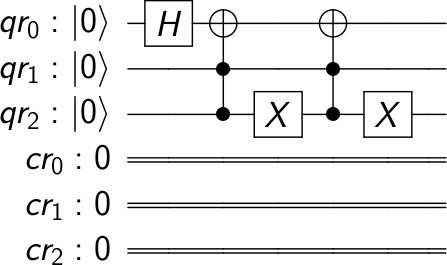

In [6]:
circuit_drawer(qc)

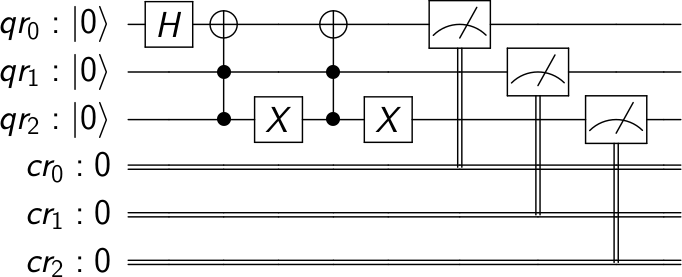

In [7]:
qc.measure(qr[0], cr[0])
qc.measure(qr[1], cr[1])
qc.measure(qr[2], cr[2])

circuit_drawer(qc)

In [8]:
qp.get_circuit_names()

['Circuit']

In [9]:
# QASM from a program

QASM_source = qp.get_qasm('Circuit')

print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[3];
creg cr[3];
h qr[0];
ccx qr[2],qr[1],qr[0];
x qr[2];
ccx qr[2],qr[1],qr[0];
x qr[2];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];



Status @ 0 seconds
{'status': <JobStatus.RUNNING: 'job is actively running'>, 'status_msg': None}
{'status': <JobStatus.DONE: 'job has successfully run'>, 'status_msg': None}
{'000': 518, '001': 506}


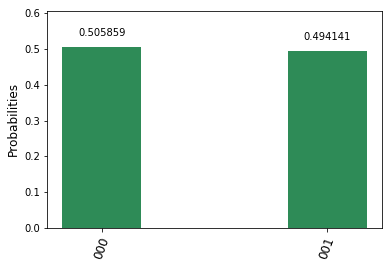

In [10]:
#other way complire and run:
job = execute(qc, backend='local_qasm_simulator', shots=1024, max_credits=3)

lapse = 0
interval = 5
while not job.done:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status)
    time.sleep(interval)
    lapse += 1
print(job.status)

print(job.result().get_counts(qc))
plot_histogram(job.result().get_counts(qc))

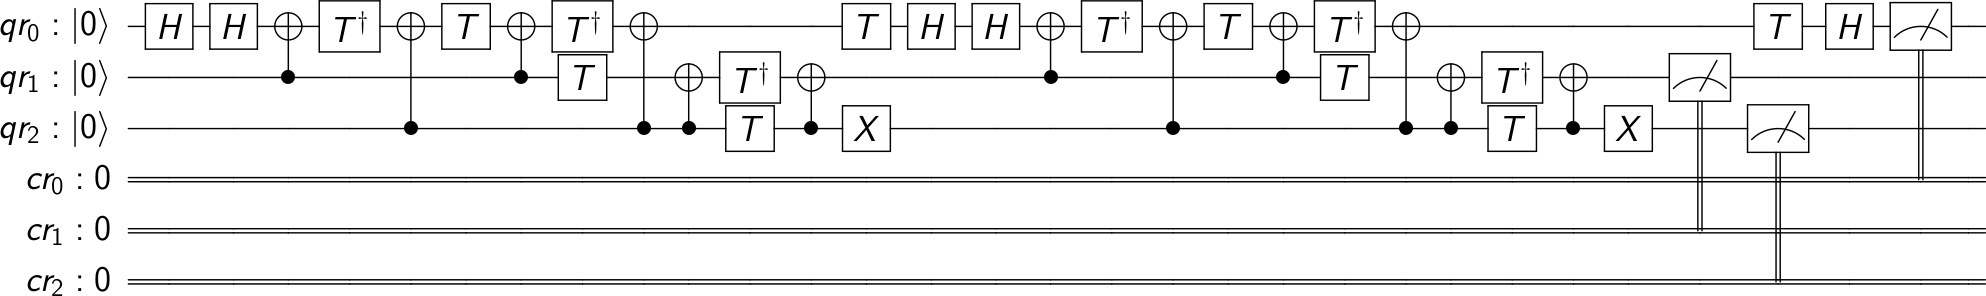

In [11]:
#the circuit running is not the one we write
qobj = compile(qc, backend='local_qasm_simulator')

qasm_str = qp.get_compiled_qasm(qobj, 'Circuit')

qasm_circ = qiskit.load_qasm_string(qasm_str);
circuit_drawer(qasm_circ)

In [12]:
print(qasm_str)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[3];
creg cr[3];
h qr[0];
h qr[0];
cx qr[1],qr[0];
tdg qr[0];
cx qr[2],qr[0];
t qr[0];
cx qr[1],qr[0];
t qr[1];
tdg qr[0];
cx qr[2],qr[0];
cx qr[2],qr[1];
tdg qr[1];
t qr[2];
cx qr[2],qr[1];
x qr[2];
t qr[0];
h qr[0];
h qr[0];
cx qr[1],qr[0];
tdg qr[0];
cx qr[2],qr[0];
t qr[0];
cx qr[1],qr[0];
t qr[1];
tdg qr[0];
cx qr[2],qr[0];
cx qr[2],qr[1];
tdg qr[1];
t qr[2];
cx qr[2],qr[1];
x qr[2];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];
t qr[0];
h qr[0];
measure qr[0] -> cr[0];



# Running on a real device

In [13]:
def lowest_pending_jobs():
    """Returns the backend with lowest pending jobs."""
    list_of_backends = available_backends(
        {'local': False, 'simulator': False})
    device_status = [get_backend(backend).status
                     for backend in list_of_backends]

    best = min([x for x in device_status if x['operational'] is True],
               key=lambda x: x['pending_jobs'])
    return best['name']

backend = lowest_pending_jobs()
print("The best backend is " + backend)

The best backend is ibmqx4


In [14]:
backend = 'ibmqx4'

api.backend_status(backend)

{'available': True, 'backend': 'ibmqx4', 'pending_jobs': 0}

In [15]:
api.backend_calibration(backend)

{'backend': 'ibmqx4',
 'lastUpdateDate': '2018-08-11T09:59:16.000Z',
 'multiQubitGates': [{'gateError': {'date': '2018-08-11T09:59:16Z',
    'value': 0.03201069768914974},
   'name': 'CX1_0',
   'qubits': [1, 0],
   'type': 'CX'},
  {'gateError': {'date': '2018-08-11T09:59:16Z',
    'value': 0.029968052150636026},
   'name': 'CX2_0',
   'qubits': [2, 0],
   'type': 'CX'},
  {'gateError': {'date': '2018-08-11T09:59:16Z', 'value': 0.04274838887512861},
   'name': 'CX2_1',
   'qubits': [2, 1],
   'type': 'CX'},
  {'gateError': {'date': '2018-08-11T09:59:16Z', 'value': 0.07511330296816435},
   'name': 'CX3_2',
   'qubits': [3, 2],
   'type': 'CX'},
  {'gateError': {'date': '2018-08-11T09:59:16Z',
    'value': 0.043160360120871516},
   'name': 'CX3_4',
   'qubits': [3, 4],
   'type': 'CX'},
  {'gateError': {'date': '2018-08-11T09:59:16Z', 'value': 0.05225436125634389},
   'name': 'CX4_2',
   'qubits': [4, 2],
   'type': 'CX'}],
 'qubits': [{'gateError': {'date': '2018-08-11T09:59:16Z',
    

In [16]:
api.backend_parameters(backend)

{'backend': 'ibmqx4',
 'fridgeParameters': {'Temperature': {'date': '-', 'unit': '-', 'value': []},
  'cooldownDate': '2017-09-07'},
 'lastUpdateDate': '2018-08-11T09:59:16.000Z',
 'qubits': [{'T1': {'date': '2018-08-11T09:59:16Z', 'unit': 'µs', 'value': 48},
   'T2': {'date': '2018-08-11T09:59:16Z', 'unit': 'µs', 'value': 45.6},
   'buffer': {'date': '2018-08-11T09:59:16Z', 'unit': 'ns', 'value': 10},
   'frequency': {'date': '2018-08-11T09:59:16Z',
    'unit': 'GHz',
    'value': 5.24985},
   'gateTime': {'date': '2018-08-11T09:59:16Z', 'unit': 'ns', 'value': 60},
   'name': 'Q0'},
  {'T1': {'date': '2018-08-11T09:59:16Z', 'unit': 'µs', 'value': 45.9},
   'T2': {'date': '2018-08-11T09:59:16Z', 'unit': 'µs', 'value': 24.8},
   'buffer': {'date': '2018-08-11T09:59:16Z', 'unit': 'ns', 'value': 10},
   'frequency': {'date': '2018-08-11T09:59:16Z',
    'unit': 'GHz',
    'value': 5.29578},
   'gateTime': {'date': '2018-08-11T09:59:16Z', 'unit': 'ns', 'value': 60},
   'name': 'Q1'},
  {'T1

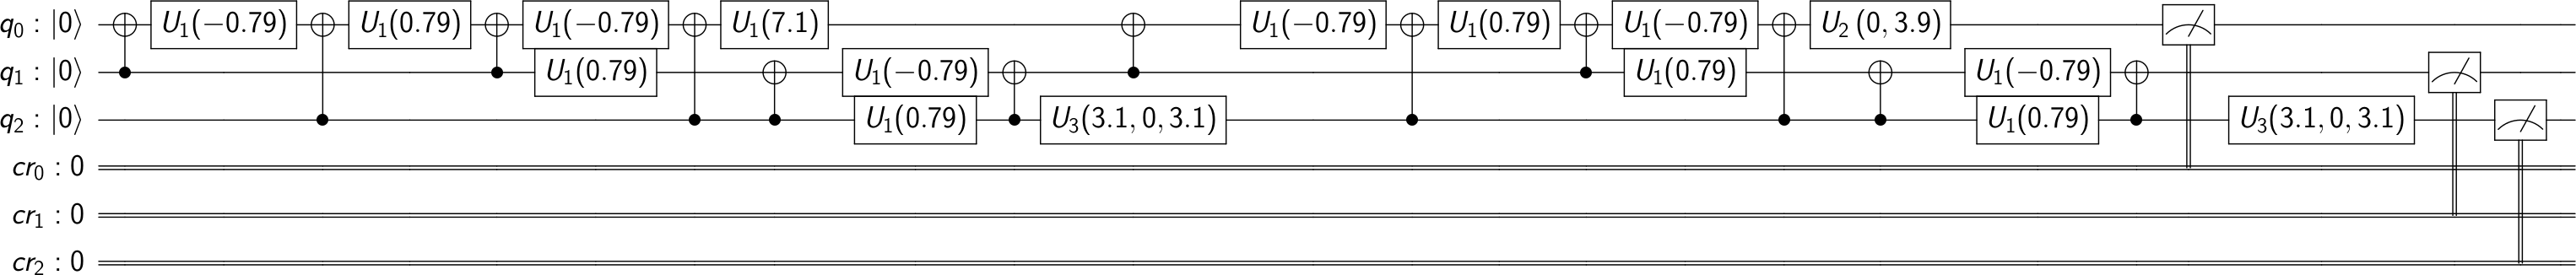

In [17]:
qobj = compile(qc, backend=backend)

qs_str = qp.get_compiled_qasm(qobj, 'Circuit')

qs_circ = qiskit.load_qasm_string(qs_str);
circuit_drawer(qs_circ)

In [18]:
print(qs_str)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg cr[3];
cx q[1],q[0];
u1(-0.785398163397448) q[0];
cx q[2],q[0];
u1(0.785398163397448) q[0];
cx q[1],q[0];
u1(0.785398163397448) q[1];
u1(-0.785398163397448) q[0];
cx q[2],q[0];
cx q[2],q[1];
u1(7.06858347057703) q[0];
u1(0.785398163397448) q[2];
u1(-0.785398163397448) q[1];
cx q[2],q[1];
u3(3.14159265358979,0,3.14159265358979) q[2];
cx q[1],q[0];
u1(-0.785398163397448) q[0];
cx q[2],q[0];
u1(0.785398163397448) q[0];
cx q[1],q[0];
u1(0.785398163397448) q[1];
u1(-0.785398163397448) q[0];
cx q[2],q[0];
cx q[2],q[1];
u2(0,3.92699081698724) q[0];
u1(0.785398163397448) q[2];
u1(-0.785398163397448) q[1];
cx q[2],q[1];
measure q[0] -> cr[0];
u3(3.14159265358979,0,3.14159265358979) q[2];
measure q[1] -> cr[1];
measure q[2] -> cr[2];



In [19]:
shots=1024
max_credits=3
job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)

lapse = 0
interval = 10
while not job_exp.done:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job_exp.status)
    time.sleep(interval)
    lapse += 1
print(job_exp.status)

Status @ 0 seconds
{'job_id': None, 'status': <JobStatus.INITIALIZING: 'job is being initialized'>, 'status_msg': 'Job is initializing. Please, wait a moment.'}
Status @ 10 seconds
{'job_id': '5b6f3e59b127f5003829280a', 'status': <JobStatus.RUNNING: 'job is actively running'>, 'status_msg': 'job is actively running'}
Status @ 20 seconds
{'job_id': '5b6f3e59b127f5003829280a', 'status': <JobStatus.DONE: 'job has successfully run'>, 'status_msg': 'job has successfully run'}
{'job_id': '5b6f3e59b127f5003829280a', 'status': <JobStatus.DONE: 'job has successfully run'>, 'status_msg': 'job has successfully run'}


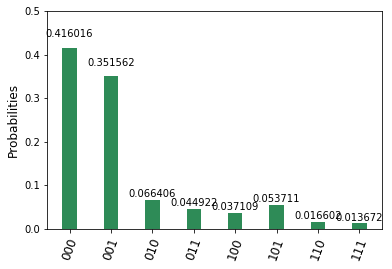

In [20]:
plot_histogram(job_exp.result().get_counts(qc))

In [21]:
job_exp.result().get_data('Circuit')

{'counts': {'000': 426,
  '001': 360,
  '010': 68,
  '011': 46,
  '100': 38,
  '101': 55,
  '110': 17,
  '111': 14},
 'date': '2018-08-11T19:52:18.566Z',
 'time': 24.5993869304657}